In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
keras = tf.keras
from utils import utils 
from importlib import reload 
print(tf.__version__)

2.3.0


In [2]:
N = 100 # time disrectization    
m = 1 # dimension of price
S0 = 1 # initial value of the asset
T = 1 # maturity
strike = 1.0
option_type = 'eurodigitalcall'
if option_type == 'eurocall':
    payoff_function = lambda x : 0.5*(np.abs(x-strike)+x-strike) # European call option payoff
if option_type == 'eurodigitalcall':
    payoff_function = lambda x : (x-strike) > 0 # European digital call option payoff

### Generate price paths of Black-Scholes model (exponential grid)
$$
S_{t} = S_{0}e^{\sigma W_{t} - \frac{\sigma^{2}}{2}t}
$$
<!-- 
$$
a_{0}, a_{0}q, \cdots, a_{0}q^{N-1}
$$

$$
\sum_{n=1}^{N}a_{0}q^{n-1} = a_{0}\frac{q^{N}-1}{q-1} = T
$$ -->

In [3]:
# GBM
sigma=0.2 # volatility in Black Scholes  
Ktrain = 10**5
price_path, time_grid_equi = utils.simulate_GBM(m,Ktrain,N,T,0,sigma,S0,'equi')
price_path, time_grid_equi_exp = utils.simulate_GBM(m,Ktrain,N,T,0,sigma,S0,'exp')
price_path, time_grid_exp = utils.simulate_GBM(m,Ktrain,N,T,0,sigma,S0,'equi-exp')
payoff = payoff_function(price_path[:,-1,:]) 
delta_output, delta_path, option_path = utils.delta_hedge(price_path,payoff,T,strike,sigma,option_type,time_grid_equi)

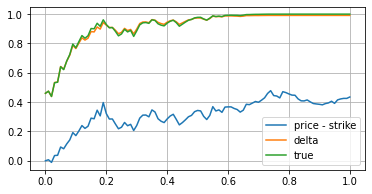

In [4]:
for i in range(1):
    plt.figure(figsize = [6,3])
    plt.plot(time_grid_equi, price_path[i,:,0].T -S0, label = 'price - strike')
    plt.plot(time_grid_equi, delta_path[i,:,0].T, label = 'delta')
    plt.plot(time_grid_equi, option_path[i,:,0].T, label = 'true')
    plt.legend()
    plt.grid()
    plt.show()

### Build the deep hedging dynamic 
Value process
$$
V_{t} = \int_{0}^{t}H_{t}dS_{t} + \alpha \int_{0}^{t}(S_{t}dH_{t})^{2} \cdot \text{(trans_cost =True)}
$$
Objective function
\begin{equation}
\begin{split}
\min_{H_{t}}\quad E\bigg[(f(S_{T})-V_{T})^2\bigg] + \beta E\bigg[\int_{0}^{T}(C_{t} - V_{t})^{2}dt\bigg] \cdot \text{(control_path =True)}
\end{split}
\end{equation}

where $(C_{t})_{t\geq 0}$ is the call option price and $f$ is the payoff function.

In [5]:
alpha = 0.005
beta = 10
def build_dynamic(m, N, control_path, trans_cost):    
    l_hidden = 2 # number of hidden layers in strategy
    width = m + 15  # nodes in the first but last layers
    
    Networks = utils.build_network(m, width , l_hidden+1, N)
    Network0 = keras.layers.Dense(m, use_bias=False)

    price = keras.Input(shape=(N+1,m))   # S_{t}; t=0,..,N+1; (batch, N+1, m)
    payoff = keras.Input(shape=(1))
    benchmark_hedge = keras.Input(shape=(N+1,m))   # V_{t}; t=0,..,N+1; (batch, N+1, m)
    
    if control_path:
        inputs = [price, payoff, benchmark_hedge]
    else:
        inputs = [price, payoff]
        
    price_difference = price[:,1:,:] - price[:,:-1,:]  # dS_{t}; t=0,..,N; (batch, N, m)
    premium = Network0(tf.ones_like(price[:,0,:])) # premium; (batch, m)
    
    HEDGE = [None]*(N+1)
    HEDGE[0] = tf.zeros_like(price[:,0,:]) + premium
    
    STRATEGY = [None]*N
    for j in range(N):
        STRATEGY[j] = Networks[j](tf.math.log(price[:,j,:]))  # H_{t} = nn(S_{t}); (batch, m)
        cost = 0
        if trans_cost: 
            if j > 0:
                cost = alpha*((STRATEGY[j]- STRATEGY[j-1])*price[:,j,:])**2
        HEDGE[j+1] = HEDGE[j] + STRATEGY[j] * price_difference[:,j,:] - cost # dX_{t} = H_{t}dS_{t}; (batch, m)
    payoff_hedge = tf.math.reduce_sum(HEDGE[-1],axis = -1, keepdims = True) # premium + \int_{0}^{T}H_{t}dS_{t}; (batch, m)
    outputs = tf.concat([h[:,None,:] for h in HEDGE], axis = 1)
    model_hedge = keras.Model(inputs = inputs, outputs= outputs)
    
    mse = tf.keras.losses.MeanSquaredError()
    model_hedge.add_loss(mse(payoff_hedge, payoff)) 
    if control_path:
        for j in range(N):
            model_hedge.add_loss(beta * mse(HEDGE[j], benchmark_hedge[:,j]))
                
    return model_hedge, Networks, Network0


In [6]:
class Model_hedge:
    def __init__(self, m, N, control_path, trans_cost):
        self.m = m
        self.N = N
        self.control_path = control_path
        self.trans_cost = trans_cost
        self.model, self.Networks, self.Network0 = build_dynamic(m, N, control_path, trans_cost)   
    def prepare_data(self, time_grid, price_path, option_path, payoff, delta_path, option_type):
        self.delta_path = delta_path
        self.option_type = option_type
        self.time_grid = time_grid
        self.option_path = option_path
        self.price_path = price_path
        self.payoff = payoff
        Ktrain = price_path.shape[0]
        split = int(Ktrain/2)
        self.split = split
        if not self.control_path:
            option_path = price_path
            self.xtrain = [price_path[:split],payoff[:split]]  
            self.ytrain = payoff[:split]*0
            self.xtest = [price_path[split:],payoff[split:]] 
            self.ytest = payoff[split:]*0
        else:
            self.xtrain = [price_path[:split],payoff[:split],option_path[:split]]  
            self.ytrain = payoff[:split]*0
            self.xtest = [price_path[split:],payoff[split:],option_path[split:]] 
            self.ytest = payoff[split:]*0 
    def train(self, epochs, verbose):
        def zeroloss(y_true, y_predict):
            return tf.reduce_sum(y_true*0)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # specify the optmizer 
        self.model.compile(optimizer = optimizer, loss=zeroloss) 
        self.model.fit(x=self.xtrain,y=self.ytrain, epochs=epochs,verbose=verbose,batch_size=1000) # train the model 
    def predict(self):
        self.hedge_output_train = self.model.predict(self.xtrain) 
        self.hedge_output_test = self.model.predict(self.xtest) 
        return self.hedge_output_train, self.hedge_output_test
    def plot(self,price_path, payoff, delta_output):
        self.delta_output = delta_output
        split = self.split
        f,p = plt.subplots(1,3, figsize = [20,5], sharey = True)
        p[0].scatter(price_path[split:,-1,0], self.hedge_output_test[:,-1,0], s = 1, alpha = 0.5, label = 'deep hedge test ')   # deep replicate payoff 
        p[1].scatter(price_path[:split,-1,0], self.hedge_output_train[:,-1,0], s = 1, alpha = 0.5, label = 'deep hedge train')   # deep replicate payoff 
        p[2].scatter(price_path[:,-1,0], delta_output[:,0], s = 1, alpha = 0.5, label = 'delta hedge')   # delta replicate payoff 
        for i in range(3):
            p[i].scatter(price_path[:,-1,0], payoff[:,0], s = 1, alpha = 0.5, label = 'real payoff')        # real payoff
            p[i].legend()
            p[i].grid()
        plt.show()
        print(f"deep premium: {self.Network0(tf.ones([1,1])).numpy()[0,0]:{1}.{5}}")         # premium of deep hedge (truncted printing)
        helper,_ = utils.BlackScholes(T, S0, strike, sigma, self.option_type)
        print(f"real premium: {helper:{1}.{5}}")           # real premium

        f,p = plt.subplots(1,4,figsize = [20,3])
        for i in range(4):
            n = 25*i + 10
            pr = np.linspace(0.5,2,100)[:,None]  # tf.tensor of different price 

            he = self.Networks[n](np.log(pr)) # the stategy network 
            p[i].plot(pr[:,0],he[:,0], label = 'deep hedge') # plot the relation between price and deep strategy
            _,delta = utils.BlackScholes(T - self.time_grid[n], pr, strike, sigma, self.option_type)
            p[i].plot(pr, delta, label = 'delta hedge') # plot the relation between price and delta strategy
            p[i].title.set_text(f"At time: {self.time_grid[n]:{1}.{4}}")
            p[i].legend()
            p[i].grid()
        plt.show()
        

In [38]:
def experiment(TIME_GRID, CONTROL, TRANS, TYPE):
    MODEL = []
    for option_type in TYPE:
        if option_type == 'eurocall':
            payoff_function = lambda x : 0.5*(np.abs(x-strike)+x-strike) # European call option payoff
        if option_type == 'eurodigitalcall':
            payoff_function = lambda x : (x-strike) > 0 # European digital call option payoff
        for time_grid_type in TIME_GRID:
            price_path, time_grid = utils.simulate_GBM(m,Ktrain,N,T,0,sigma,S0,time_grid_type)
            payoff = payoff_function(price_path[:,-1,:]) 
            delta_output, delta_path, option_path = utils.delta_hedge(price_path,payoff,T,strike,sigma,option_type,time_grid)
            for control_path in CONTROL:
                for trans_cost in TRANS:
                    if control_path and trans_cost:
                        pass
                    else:
                        print('option_type: ',option_type)
                        print('time_grid_type: ',time_grid_type)
                        print('control_path: ', control_path)
                        print('trans_cost: ', trans_cost)

                        model_hedge = Model_hedge(m, N, control_path, trans_cost)
                        model_hedge.prepare_data(time_grid, price_path, option_path, payoff, delta_path, option_type)
                        print('TRAINING............')
                        epochs = 20
                        if time_grid_type == 'exp':
                            epochs = 50
                        model_hedge.train(epochs = epochs,verbose = True)
                        model_hedge.predict()
                        model_hedge.plot(price_path, payoff, delta_output)
                        MODEL.append(model_hedge)
    return MODEL

option_type:  eurocall
time_grid_type:  equi
control_path:  False
trans_cost:  False
TRAINING............
Epoch 1/20
50/50 [==============================] - 1s 11ms/step - loss: 1.5142
Epoch 2/20
50/50 [==============================] - 1s 11ms/step - loss: 0.6300
Epoch 3/20
50/50 [==============================] - 1s 11ms/step - loss: 0.2179
Epoch 4/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0612
Epoch 5/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0140
Epoch 6/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0027
Epoch 7/20
50/50 [==============================] - 1s 11ms/step - loss: 5.9397e-04
Epoch 8/20
50/50 [==============================] - 1s 11ms/step - loss: 2.3219e-04
Epoch 9/20
50/50 [==============================] - 1s 11ms/step - loss: 1.5561e-04
Epoch 10/20
50/50 [==============================] - 1s 11ms/step - loss: 1.1869e-04
Epoch 11/20
50/50 [==============================] - 1s 11ms/step - loss: 9.7

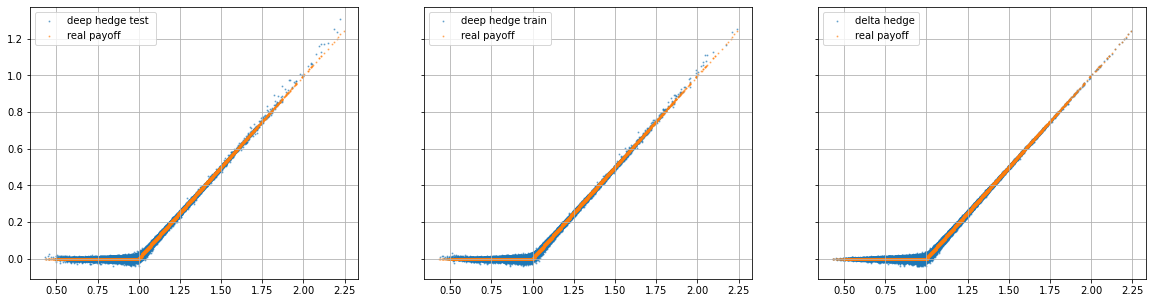

deep premium: 0.079618
real premium: 0.079656


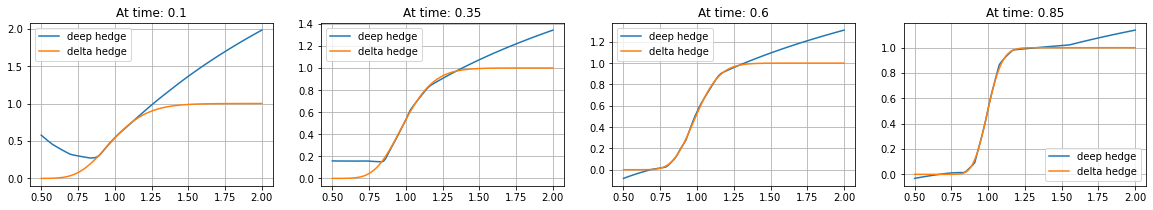

In [8]:
TIME_GRID = ['equi']
CONTROL = [False]
TRANS = [False]
TYPE = ['eurocall']
MODEL = experiment(TIME_GRID, CONTROL, TRANS, TYPE)
model_hedge_call = MODEL[0]

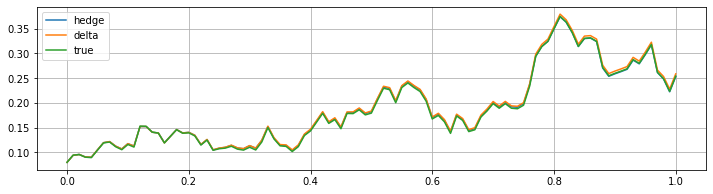

In [9]:
i = np.random.randint(0,model_hedge_call.split)
plt.figure(figsize = [12,3])
plt.plot(model_hedge_call.time_grid,model_hedge_call.hedge_output_train[i,:,0], label = 'hedge')
plt.plot(model_hedge_call.time_grid,model_hedge_call.delta_path[i,:,0], label = 'delta')
plt.plot(model_hedge_call.time_grid,model_hedge_call.option_path[i,:,0], label = 'true')
plt.legend()
plt.grid()
plt.show()

option_type:  eurodigitalcall
time_grid_type:  equi
control_path:  False
trans_cost:  False
TRAINING............
Epoch 1/20
50/50 [==============================] - 1s 12ms/step - loss: 3.1417
Epoch 2/20
50/50 [==============================] - 1s 12ms/step - loss: 1.7053
Epoch 3/20
50/50 [==============================] - 1s 11ms/step - loss: 0.8662
Epoch 4/20
50/50 [==============================] - 1s 11ms/step - loss: 0.4084
Epoch 5/20
50/50 [==============================] - 1s 12ms/step - loss: 0.1847
Epoch 6/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0856
Epoch 7/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0458
Epoch 8/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0301
Epoch 9/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0235
Epoch 10/20
50/50 [==============================] - 1s 12ms/step - loss: 0.0202
Epoch 11/20
50/50 [==============================] - 1s 12ms/step - loss: 0.0187
Epoch

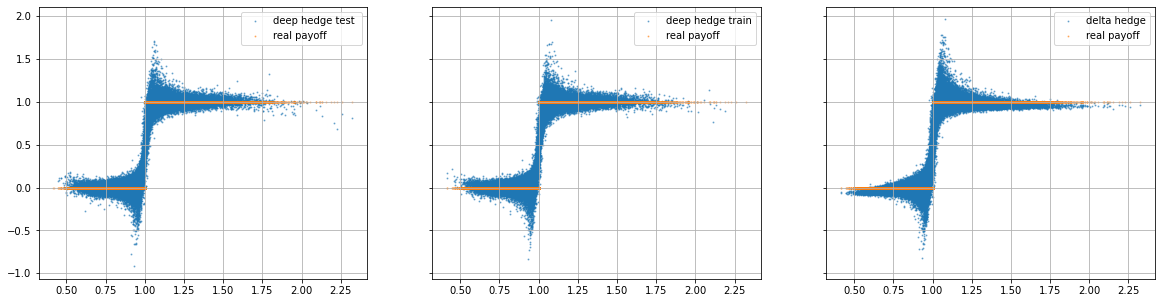

deep premium: 0.45912
real premium: 0.46017


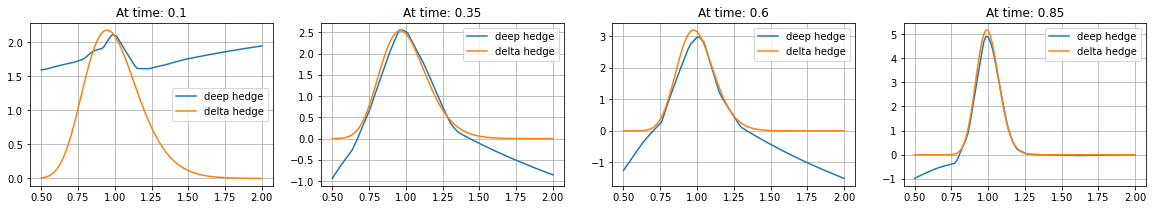

In [10]:
TIME_GRID = ['equi']
CONTROL = [False]
TRANS = [False]
TYPE = ['eurodigitalcall']
MODEL = experiment(TIME_GRID, CONTROL, TRANS, TYPE)
model_hedge_call_digital = MODEL[0]

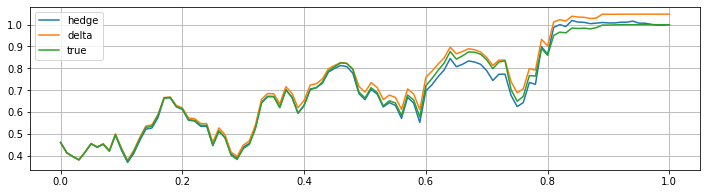

In [11]:
i = np.random.randint(0,model_hedge_call_digital.split)
plt.figure(figsize = [12,3])
plt.plot(model_hedge_call_digital.time_grid,model_hedge_call_digital.hedge_output_train[i,:,0], label = 'hedge')
plt.plot(model_hedge_call_digital.time_grid,model_hedge_call_digital.delta_path[i,:,0], label = 'delta')
plt.plot(model_hedge_call_digital.time_grid,model_hedge_call_digital.option_path[i,:,0], label = 'true')
plt.legend()
plt.grid()
plt.show()

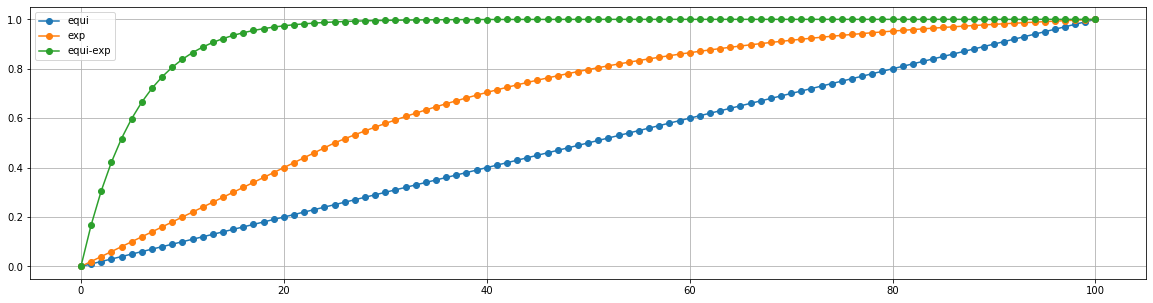

In [14]:
plt.figure(figsize = [20,5])
plt.plot(np.arange(len(time_grid_equi)), time_grid_equi, '-o', label = 'equi')
plt.plot(np.arange(len(time_grid_exp)), time_grid_exp, '-o', label = 'exp')
plt.plot(np.arange(len(time_grid_equi_exp)), time_grid_equi_exp, '-o', label = 'equi-exp')
plt.legend()
plt.grid()

option_type:  eurodigitalcall
time_grid_type:  equi
control_path:  False
trans_cost:  False
TRAINING............
Epoch 1/20
50/50 [==============================] - 1s 12ms/step - loss: 0.2306
Epoch 2/20
50/50 [==============================] - 1s 12ms/step - loss: 0.0545
Epoch 3/20
50/50 [==============================] - 1s 12ms/step - loss: 0.0346
Epoch 4/20
50/50 [==============================] - 1s 13ms/step - loss: 0.0277
Epoch 5/20
50/50 [==============================] - 1s 14ms/step - loss: 0.0229
Epoch 6/20
50/50 [==============================] - 1s 13ms/step - loss: 0.0202
Epoch 7/20
50/50 [==============================] - 1s 12ms/step - loss: 0.0190
Epoch 8/20
50/50 [==============================] - 1s 13ms/step - loss: 0.0183
Epoch 9/20
50/50 [==============================] - 1s 13ms/step - loss: 0.0179
Epoch 10/20
50/50 [==============================] - 1s 13ms/step - loss: 0.0177
Epoch 11/20
50/50 [==============================] - 1s 13ms/step - loss: 0.0176
Epoch

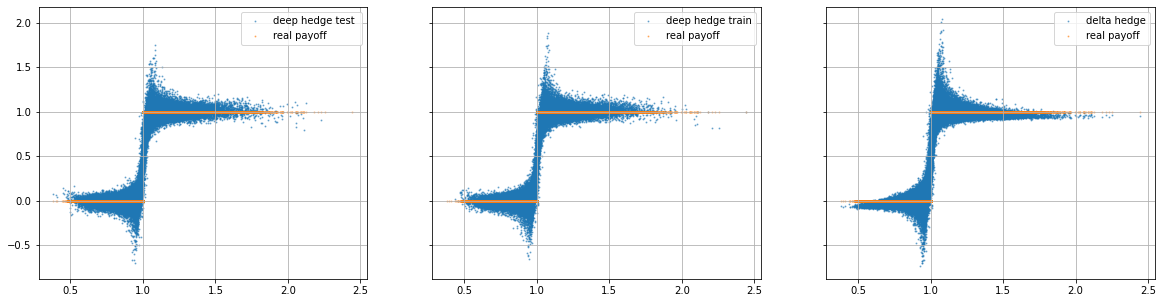

deep premium: 0.46049
real premium: 0.46017


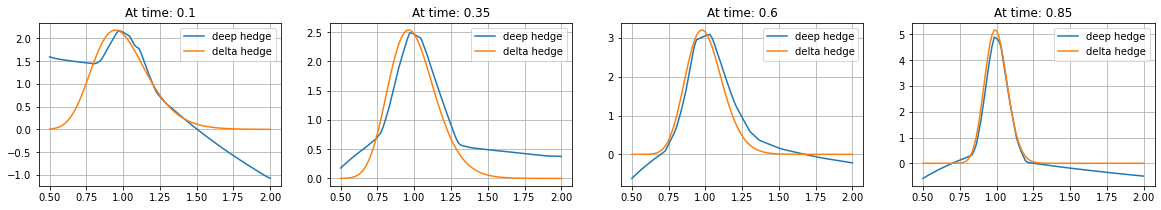

option_type:  eurodigitalcall
time_grid_type:  exp
control_path:  False
trans_cost:  False
TRAINING............
Epoch 1/50
50/50 [==============================] - 1s 14ms/step - loss: 0.2480
Epoch 2/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0576
Epoch 3/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0370
Epoch 4/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0304
Epoch 5/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0267
Epoch 6/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0239
Epoch 7/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0219
Epoch 8/50
50/50 [==============================] - 1s 16ms/step - loss: 0.0205
Epoch 9/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0195
Epoch 10/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0185
Epoch 11/50
50/50 [==============================] - 1s 16ms/step - loss: 0.0179
Epoch 

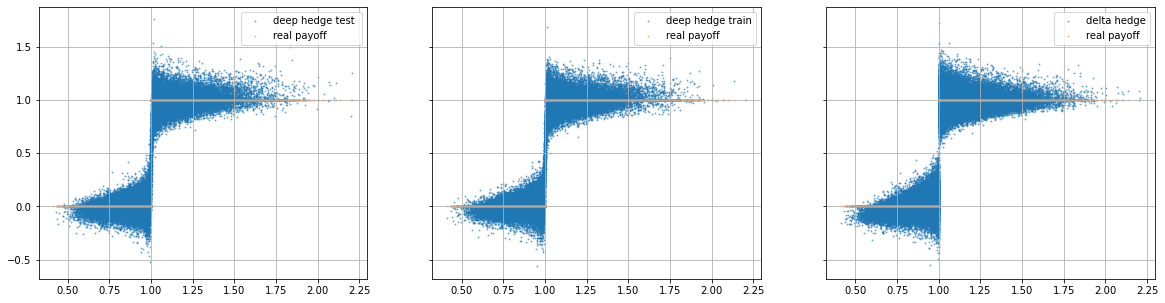

deep premium: 0.46067
real premium: 0.46017


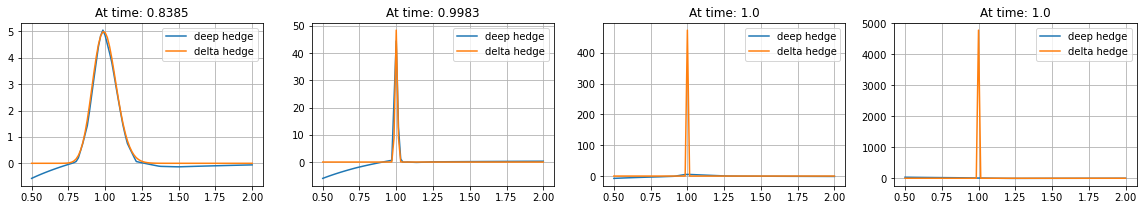

option_type:  eurodigitalcall
time_grid_type:  equi-exp
control_path:  False
trans_cost:  False
TRAINING............
Epoch 1/20
50/50 [==============================] - 1s 19ms/step - loss: 0.2898
Epoch 2/20
50/50 [==============================] - 1s 21ms/step - loss: 0.0683
Epoch 3/20
50/50 [==============================] - 1s 20ms/step - loss: 0.0385
Epoch 4/20
50/50 [==============================] - 1s 21ms/step - loss: 0.0291
Epoch 5/20
50/50 [==============================] - 1s 20ms/step - loss: 0.0231
Epoch 6/20
50/50 [==============================] - 1s 20ms/step - loss: 0.0192
Epoch 7/20
50/50 [==============================] - 1s 21ms/step - loss: 0.0165
Epoch 8/20
50/50 [==============================] - 1s 26ms/step - loss: 0.0146
Epoch 9/20
50/50 [==============================] - 1s 26ms/step - loss: 0.0130
Epoch 10/20
50/50 [==============================] - 1s 26ms/step - loss: 0.0120
Epoch 11/20
50/50 [==============================] - 1s 26ms/step - loss: 0.0114
E

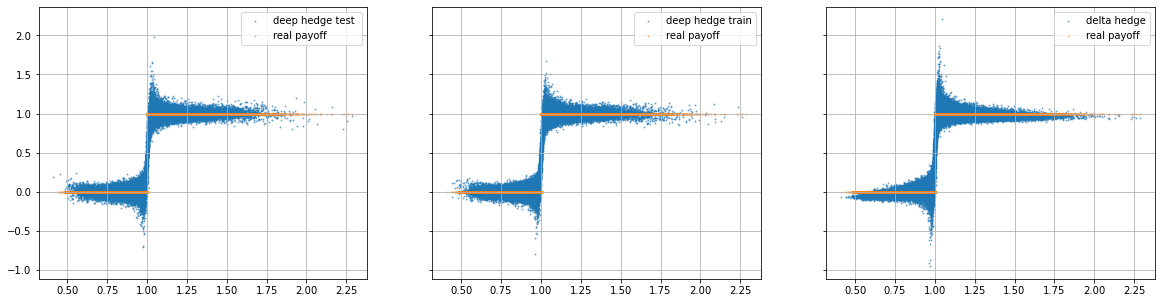

deep premium: 0.45982
real premium: 0.46017


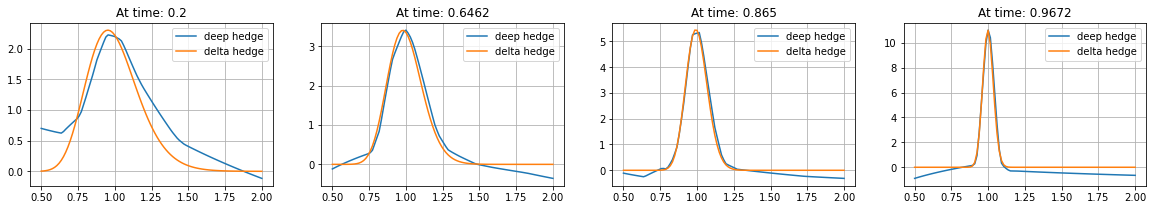

In [15]:
TIME_GRID = ['equi', 'exp', 'equi-exp']
CONTROL = [False]
TRANS = [False]
TYPE = ['eurodigitalcall']
MODEL_GRID = experiment(TIME_GRID, CONTROL, TRANS, TYPE)

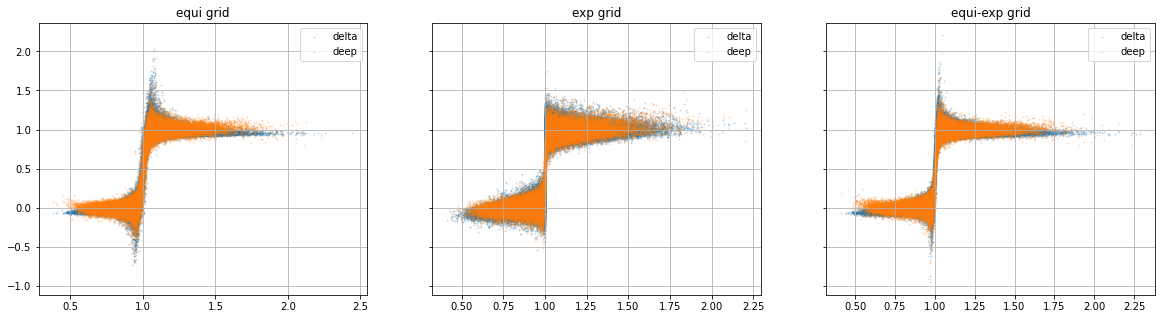

In [16]:
split = MODEL_GRID[0].split
f,p = plt.subplots(1,3, figsize = [20,5], sharey = True)
for i in range(3):
    p[i].scatter(MODEL_GRID[i].price_path[:,-1,0], MODEL_GRID[i].delta_output[:,0], s = 1, alpha = 0.2, label = 'delta')   # delta replicate payoff 
    p[i].scatter(MODEL_GRID[i].price_path[split:,-1,0], MODEL_GRID[i].hedge_output_test[:,-1,0], s = 1, alpha = 0.2, label = 'deep')   # deep replicate payoff 
    p[i].legend()
    p[i].grid()
    p[i].title.set_text(TIME_GRID[i] + ' grid')
plt.show()

In [17]:
for i in range(3):
    print('MSE of '+TIME_GRID[i] + ' GRID: ', MODEL_GRID[i].model.evaluate(MODEL_GRID[i].xtest,MODEL_GRID[i].ytest))

1563/1563 [==============================] - 4s 3ms/step - loss: 0.0173
MSE of equi GRID:  0.017276450991630554
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0119
MSE of exp GRID:  0.0118554113432765
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0097
MSE of equi-exp GRID:  0.009687897749245167


In [18]:
for i in range(3):
    diff = MODEL_GRID[i].hedge_output_test[:,-1,0] - MODEL_GRID[i].payoff[split:,0]
    print('MAX NORM of '+TIME_GRID[i] + ' GRID: ', np.abs(diff).max())
plt.show()

MAX NORM of equi GRID:  1.0816971
MAX NORM of exp GRID:  1.00911
MAX NORM of equi-exp GRID:  0.9845637


option_type:  eurodigitalcall
time_grid_type:  equi-exp
control_path:  False
trans_cost:  False
TRAINING............
Epoch 1/20
50/50 [==============================] - 1s 25ms/step - loss: 0.1245
Epoch 2/20
50/50 [==============================] - 1s 25ms/step - loss: 0.0526
Epoch 3/20
50/50 [==============================] - 1s 25ms/step - loss: 0.0346
Epoch 4/20
50/50 [==============================] - 1s 24ms/step - loss: 0.0266
Epoch 5/20
50/50 [==============================] - 1s 23ms/step - loss: 0.0212
Epoch 6/20
50/50 [==============================] - 1s 24ms/step - loss: 0.0173
Epoch 7/20
50/50 [==============================] - 1s 24ms/step - loss: 0.0146
Epoch 8/20
50/50 [==============================] - 1s 24ms/step - loss: 0.0129
Epoch 9/20
50/50 [==============================] - 1s 28ms/step - loss: 0.0118
Epoch 10/20
50/50 [==============================] - 1s 29ms/step - loss: 0.0110
Epoch 11/20
50/50 [==============================] - 1s 29ms/step - loss: 0.0105
E

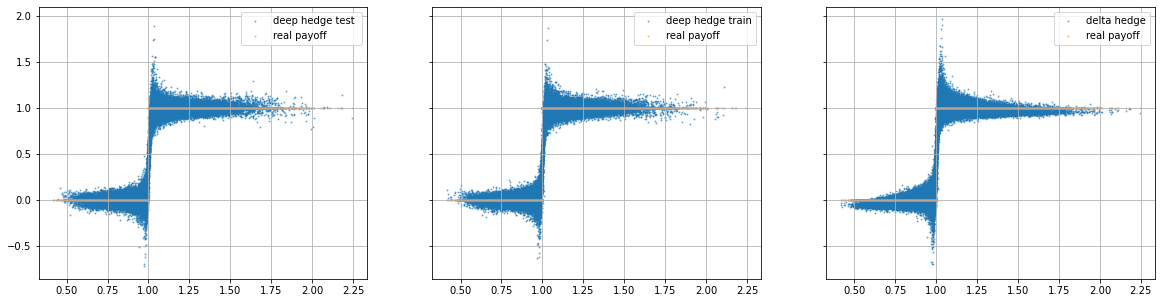

deep premium: 0.45688
real premium: 0.46017


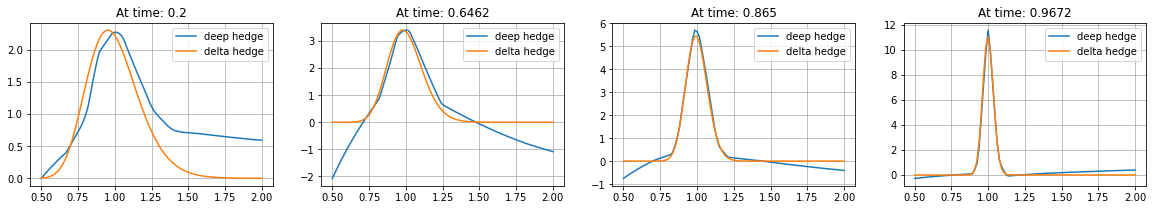

option_type:  eurodigitalcall
time_grid_type:  equi-exp
control_path:  True
trans_cost:  False
TRAINING............
Epoch 1/20
50/50 [==============================] - 1s 28ms/step - loss: 2795.4529
Epoch 2/20
50/50 [==============================] - 1s 28ms/step - loss: 1464.3652
Epoch 3/20
50/50 [==============================] - 1s 28ms/step - loss: 702.1628
Epoch 4/20
50/50 [==============================] - 2s 31ms/step - loss: 302.0914
Epoch 5/20
50/50 [==============================] - 2s 34ms/step - loss: 116.7781
Epoch 6/20
50/50 [==============================] - 2s 32ms/step - loss: 41.2197
Epoch 7/20
50/50 [==============================] - 2s 32ms/step - loss: 14.1412
Epoch 8/20
50/50 [==============================] - 2s 34ms/step - loss: 5.4613
Epoch 9/20
50/50 [==============================] - 2s 34ms/step - loss: 2.7604
Epoch 10/20
50/50 [==============================] - 2s 33ms/step - loss: 1.8492
Epoch 11/20
50/50 [==============================] - 2s 33ms/step - l

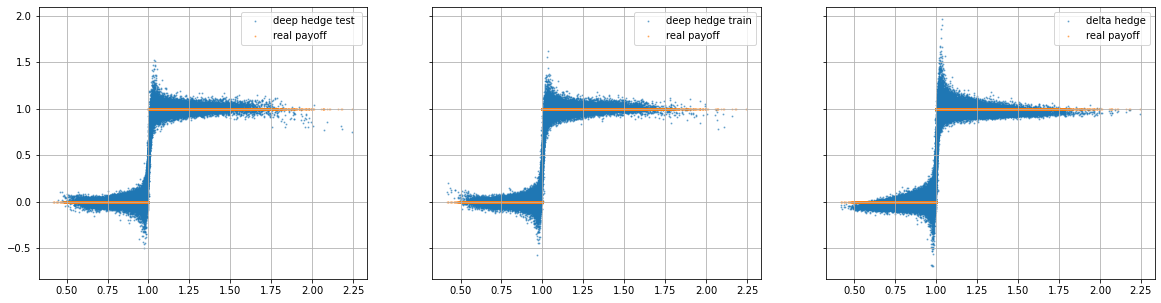

deep premium: 0.46
real premium: 0.46017


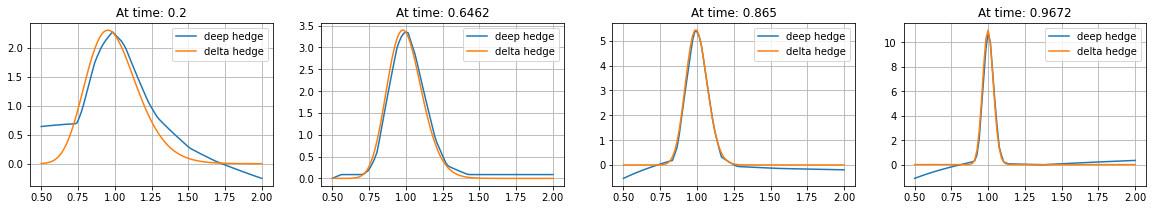

In [19]:
TIME_GRID = ['equi-exp']
CONTROL = [False, True]
TRANS = [False]
TYPE = ['eurodigitalcall']
MODEL = experiment(TIME_GRID, CONTROL, TRANS, TYPE)
MODEL_CONTROL = MODEL

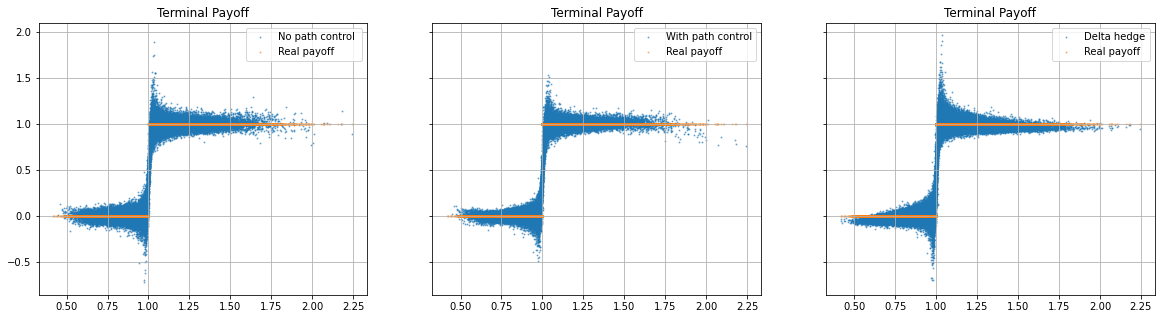

In [20]:
split = MODEL_CONTROL[0].split
f,p = plt.subplots(1,3, figsize = [20,5], sharey = True)
p[0].scatter(MODEL_CONTROL[0].price_path[split:,-1,0], MODEL_CONTROL[0].hedge_output_test[:,-1,0], s = 1, alpha = 0.5, label = 'No path control ')   # deep replicate payoff 
p[1].scatter(MODEL_CONTROL[1].price_path[split:,-1,0], MODEL_CONTROL[1].hedge_output_test[:,-1,0], s = 1, alpha = 0.5, label = 'With path control')  
p[2].scatter(MODEL_CONTROL[1].price_path[:,-1,0], MODEL_CONTROL[1].delta_output[:,0], s = 1, alpha = 0.5, label = 'Delta hedge')   # delta replicate payoff 
for i in range(3):
    p[i].scatter(MODEL_CONTROL[0].price_path[:,-1,0], MODEL_CONTROL[0].payoff[:,0], s = 1, alpha = 0.5, label = 'Real payoff')        # real payoff
    p[i].title.set_text('Terminal Payoff')
    p[i].legend()
    p[i].grid()
plt.show()

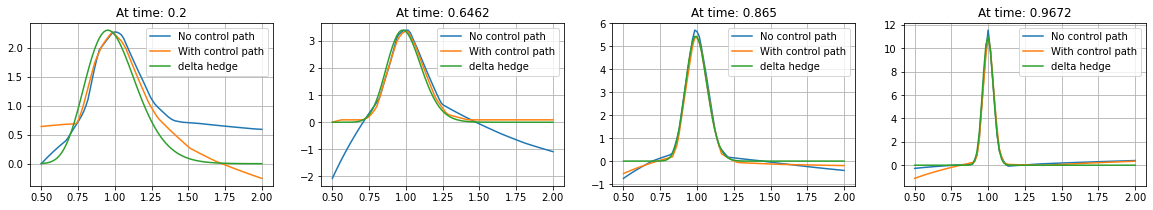

In [21]:
f,p = plt.subplots(1,4,figsize = [20,3])
for i in range(4):
    n = 25*i + 10
    pr = np.linspace(0.5,2,100)[:,None]  # tf.tensor of different price 

    he = MODEL_CONTROL[0].Networks[n](np.log(pr)) # the stategy network 
    p[i].plot(pr[:,0],he[:,0], label = 'No control path') # plot the relation between price and deep strategy
    
    he = MODEL_CONTROL[1].Networks[n](np.log(pr)) # the stategy network 
    p[i].plot(pr[:,0],he[:,0], label = 'With control path') # plot the relation between price and deep strategy
    
    _,delta = utils.BlackScholes(T - MODEL_CONTROL[0].time_grid[n], pr, strike, sigma, option_type)
    p[i].plot(pr, delta, label = 'delta hedge') # plot the relation between price and delta strategy
    p[i].title.set_text(f"At time: {MODEL_CONTROL[0].time_grid[n]:{1}.{4}}")
    p[i].legend()
    p[i].grid()
plt.show()

In [22]:
diff = MODEL_CONTROL[0].hedge_output_test[:,-1,0] - MODEL_CONTROL[0].payoff[split:,0]
print('MSE without control: ' , (diff**2).mean())
diff = MODEL_CONTROL[1].hedge_output_test[:,-1,0] - MODEL_CONTROL[1].payoff[split:,0]
print('MSE with control: ' , (diff**2).mean())
diff = MODEL_CONTROL[0].delta_output - MODEL_CONTROL[0].payoff
print('MSE of delta hedge' , (diff**2).mean())

MSE without control:  0.009414017
MSE with control:  0.008714498
MSE of delta hedge 0.008828601968607462


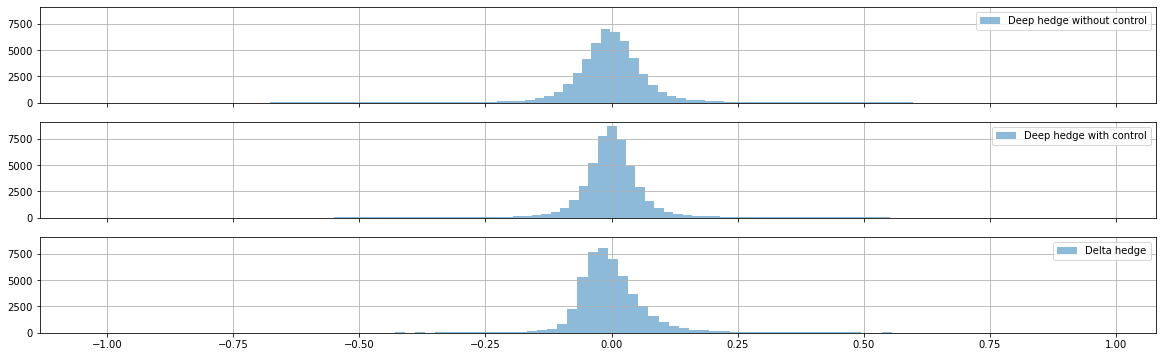

In [23]:
f,p = plt.subplots(3,1,figsize = [20,6], sharex = True, sharey = True)
for i in range(2):
    diff = MODEL_CONTROL[i].hedge_output_test[:,-1,0] - MODEL_CONTROL[i].payoff[split:,0]
    p[i].hist(diff,bins = 100,alpha = 0.5)
    p[i].grid()
diff = MODEL_CONTROL[i].delta_output[split:,0] - MODEL_CONTROL[i].payoff[split:,0]
p[2].hist(diff,bins = 100,alpha = 0.5)
p[2].grid()
p[0].legend(['Deep hedge without control'])
p[1].legend(['Deep hedge with control'])
p[2].legend(['Delta hedge'])
plt.show()

In [37]:
model_trans_call = MODEL_TRANS[0]

option_type:  eurocall
time_grid_type:  equi-exp
control_path:  False
trans_cost:  True
TRAINING............
Epoch 1/20
50/50 [==============================] - 4s 72ms/step - loss: 1.0102
Epoch 2/20
50/50 [==============================] - 4s 72ms/step - loss: 0.3404
Epoch 3/20
50/50 [==============================] - 4s 70ms/step - loss: 0.0857
Epoch 4/20
50/50 [==============================] - 4s 70ms/step - loss: 0.0158
Epoch 5/20
50/50 [==============================] - 4s 70ms/step - loss: 0.0023
Epoch 6/20
50/50 [==============================] - 4s 70ms/step - loss: 4.1913e-04
Epoch 7/20
50/50 [==============================] - 3s 70ms/step - loss: 1.7134e-04
Epoch 8/20
50/50 [==============================] - 4s 75ms/step - loss: 1.1621e-04
Epoch 9/20
50/50 [==============================] - 4s 72ms/step - loss: 1.0148e-04
Epoch 10/20
50/50 [==============================] - 4s 71ms/step - loss: 9.5838e-05
Epoch 11/20
50/50 [==============================] - 4s 71ms/step - lo

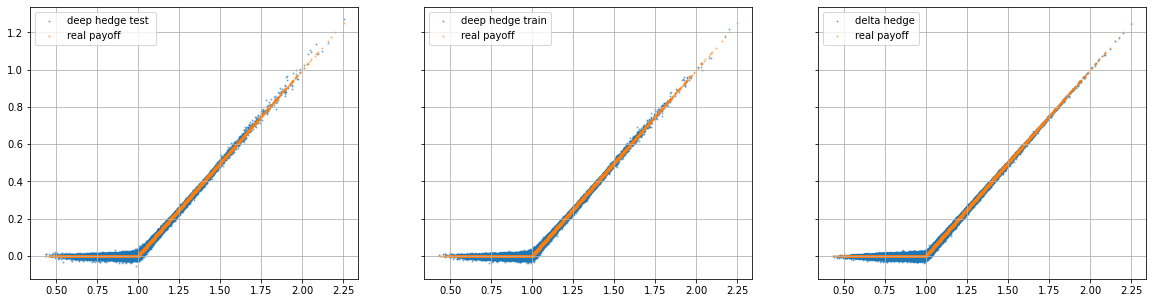

deep premium: 0.082807
real premium: 0.079656


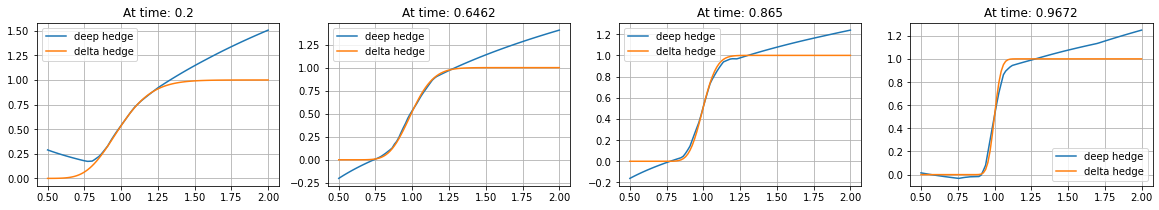

option_type:  eurodigitalcall
time_grid_type:  equi-exp
control_path:  False
trans_cost:  True
TRAINING............
Epoch 1/20
50/50 [==============================] - 4s 74ms/step - loss: 0.2935
Epoch 2/20
50/50 [==============================] - 4s 73ms/step - loss: 0.0360
Epoch 3/20
50/50 [==============================] - 4s 73ms/step - loss: 0.0225
Epoch 4/20
50/50 [==============================] - 4s 73ms/step - loss: 0.0176
Epoch 5/20
50/50 [==============================] - 4s 73ms/step - loss: 0.0157
Epoch 6/20
50/50 [==============================] - 4s 73ms/step - loss: 0.0145
Epoch 7/20
50/50 [==============================] - 4s 73ms/step - loss: 0.0140
Epoch 8/20
50/50 [==============================] - 4s 73ms/step - loss: 0.0137
Epoch 9/20
50/50 [==============================] - 4s 73ms/step - loss: 0.0134
Epoch 10/20
50/50 [==============================] - 4s 73ms/step - loss: 0.0128
Epoch 11/20
50/50 [==============================] - 4s 73ms/step - loss: 0.0126
Ep

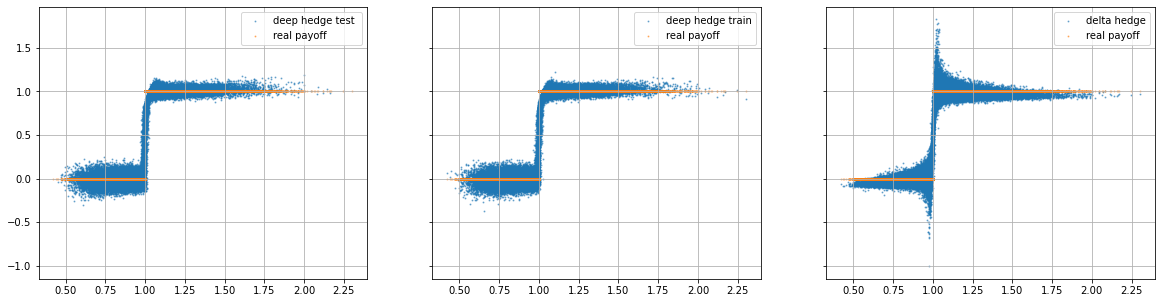

deep premium: 1.1983
real premium: 0.46017


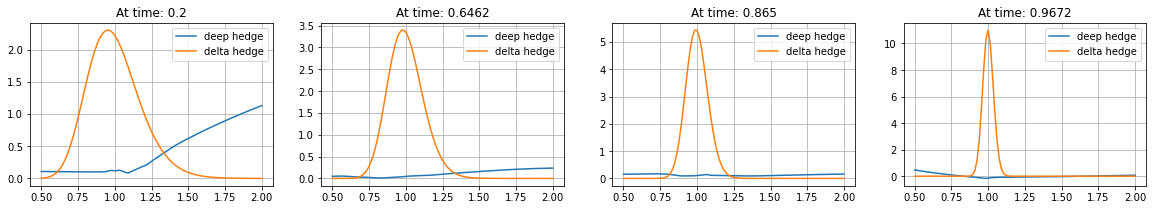

In [39]:
TIME_GRID = ['equi-exp']
CONTROL = [False]
TRANS = [True]
TYPE = ['eurocall', 'eurodigitalcall']
MODEL_TRANS = experiment(TIME_GRID, CONTROL, TRANS, TYPE)

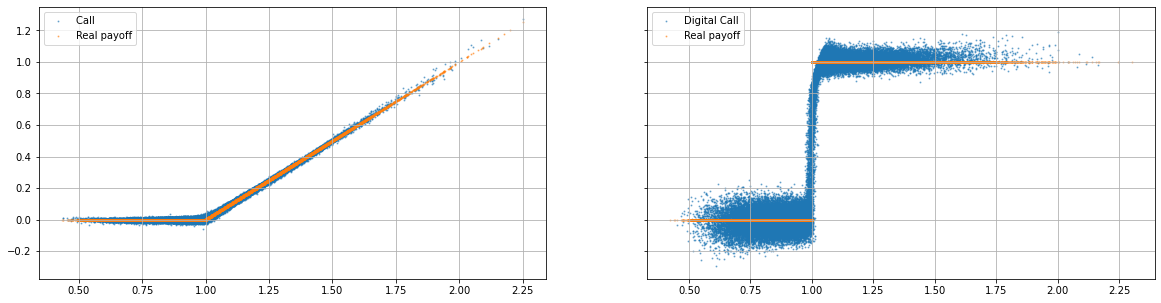

In [40]:
split = MODEL_TRANS[0].split
f,p = plt.subplots(1,2, figsize = [20,5], sharey = True)
p[0].scatter(MODEL_TRANS[0].price_path[split:,-1,0], MODEL_TRANS[0].hedge_output_test[:,-1,0], s = 1, alpha = 0.5, label = 'Call ')   # deep replicate payoff 
p[0].scatter(MODEL_TRANS[0].price_path[:,-1,0], MODEL_TRANS[0].payoff[:,0], s = 1, alpha = 0.5, label = 'Real payoff')        # real payoff
p[1].scatter(MODEL_TRANS[1].price_path[split:,-1,0], MODEL_TRANS[1].hedge_output_test[:,-1,0], s = 1, alpha = 0.5, label = 'Digital Call')     # delta replicate payoff 
p[1].scatter(MODEL_TRANS[1].price_path[:,-1,0], MODEL_TRANS[1].payoff[:,0], s = 1, alpha = 0.5, label = 'Real payoff')        # real payoff
for i in range(2):
    p[i].legend()
    p[i].grid()
plt.show()

In [41]:
def trans_cost_compute(model):
    Hedge = [None] * N
    transaction_cost = 0
    for j in range(N):
        Hedge[j] = model.Networks[j](tf.math.log(model.price_path[:,j,:]))
        if j > 0: 
            transaction_cost += alpha*(Hedge[j]*model.price_path[:,j-1,:] - Hedge[j-1]*model.price_path[:,j-1,:])**2
    print('transaction cost: ', transaction_cost[:,0].numpy().mean())

In [42]:
def trans_cost_compute_delta(model):
    Hedge = [None] * N
    transaction_cost = 0
    for j in range(N):
        _,delta = utils.BlackScholes(T - model.time_grid[n], model.price_path[:,j,:], strike, sigma, model.option_type)
        Hedge[j] = delta
        if j > 0: 
            transaction_cost += alpha*(Hedge[j]*model.price_path[:,j-1,:] - Hedge[j-1]*model.price_path[:,j-1,:])**2
    print('delta transaction cost: ', transaction_cost[:,0].mean())

In [43]:
helper0 = MODEL_TRANS[0].Network0(tf.ones([1,1])).numpy()[0,0]
print(f"deep premium: {MODEL_TRANS[0].Network0(tf.ones([1,1])).numpy()[0,0]:{1}.{5}}")         # premium of deep hedge (truncted printing)
helper,_ = utils.BlackScholes(T, S0, strike, sigma, MODEL_TRANS[0].option_type)
print(f"real premium: {helper:{1}.{5}}")           # real premium
print(f"difference: {helper0 - helper:{1}.{5}}")           # real premium
trans_cost_compute(MODEL_TRANS[0])
trans_cost_compute_delta(MODEL_TRANS[0])

deep premium: 0.082807
real premium: 0.079656
difference: 0.0031513
transaction cost:  0.002934306
delta transaction cost:  0.005001982984068858


In [44]:
helper0 = MODEL_TRANS[1].Network0(tf.ones([1,1])).numpy()[0,0]
print(f"deep premium: {MODEL_TRANS[1].Network0(tf.ones([1,1])).numpy()[0,0]:{1}.{5}}")         # premium of deep hedge (truncted printing)
helper,_ = utils.BlackScholes(T, S0, strike, sigma, MODEL_TRANS[1].option_type)
print(f"real premium: {helper:{1}.{5}}")           # real premium
print(f"difference: {helper0 - helper:{1}.{5}}")           # real premium
trans_cost_compute(MODEL_TRANS[1])
trans_cost_compute_delta(MODEL_TRANS[1])

deep premium: 1.1983
real premium: 0.46017
difference: 0.73808
transaction cost:  0.73871255
delta transaction cost:  1.5382376797472312
